# A Vanilla Image Segmentaion Model to Understand Clouds from Satellite Images

## Introduction

A vanilla image segmentation model is applied on the image data of Kaggle competition, [Understanding Clouds from Satellite Images](https://www.kaggle.com/c/understanding_cloud_organization/). The motivation of this competition is described following:

```
Shallow clouds play a huge role in determining the Earth's climate. They’re also difficult to understand and to represent in climate models. By classifying different types of cloud organization, researchers at Max Planck hope to improve our physical understanding of these clouds, which in turn will help us build better climate models.
```

In [the published paper](https://arxiv.org/pdf/1906.01906.pdf), researchers divided the cloud formation into four patterns, Sugar, Flower, Fish and Gravel. Therefore, given a batch of labeled images, it is possible to train a image segementaion model to predict the labels of test image segmentation. Since four patterns are quite different, it is natural to train 4 different models to predict the pattern segmentation.

### Dataset notes 
Several items needed to notice as mentioned in [the evaluation metric](https://www.kaggle.com/c/understanding_cloud_organization/overview/evaluation):

- Both train/test images and train image mask are `1400 x 2100`, predicted image masks on test image `350 x 525`.


### Model notes
Several useful libraries are applied in this vanilla model:
- [albumentations](https://github.com/albu/albumentations): this is a python library for image augmentation.
- [catalyst](https://github.com/catalyst-team/catalyst): this is a python library that provide high-level pyTorch APIs.
- [segmentation_models_pytorch](https://github.com/qubvel/segmentation_models.pytorch): this is a library with convenient wrappers for models, losses and other useful things.
- [pytorch-toolbelt](https://github.com/BloodAxe/pytorch-toolbelt): this is a python library to build pytorch models with short-cut.

## Data analysis

In this chapter, a basic analysis features are provided.

### Packages setup

The package installation is one time setup.

In [1]:
!pip install catalyst
!pip install pretrainedmodels
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-tsyd4gnt
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-tsyd4gnt
     |████████████████████████████████| 748.9MB 104kB/s eta 0:00:01    |████████████████▊               | 390.6MB 216kB/s eta 0:27:33��█████████████████▏      | 588.5MB 6.2MB/s eta 0:00:26��█████████████████▎      | 592.5MB 6.1MB/s eta 0:00:26     |█████████████████████████▍      | 595.4MB 6.1MB/s eta 0:00:26
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.0.3-cp36-none-any.whl size=29157 sha256=f7d9920ce7d2b3765199e6c5dbdb11bcce1a54a89d2f5d4dab6a5f7877abd3ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-7fa5kt9w/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.4.0-cp36-none-any.whl size=11149 sha256=4b5099f19a535d4448ca1c0ea351496cec2a08cfb3429091

  Found existing installation: torch 1.0.0
    Uninstalling torch-1.0.0:
      Successfully uninstalled torch-1.0.0


In [1]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import torch as AT

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp

/home/hua/anaconda3/lib/python3.6/site-packages/dask/config.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
pyarrow not available, switching to pickle. To install pyarrow, run `pip install pyarrow`.
lz4 not available, disabling compression. To install lz4, run `pip install lz4`.
wandb not available, to install wandb, run `pip install wandb`.


In [2]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [3]:
class DatasetLoader():
    def __init__(self, base_path):
        self.base_path = base_path
        self.train_image_mask_filename = "train.csv"
        self.test_image_pred_sample_filename = "sample_submission.csv"
        self.train_image_dir = "train_images"
        self.test_image_dir = "test_images"
    
    def get_dataset_list(self):
        return os.listdir(self.base_path)
    
    def get_train_image_mask_as_pandas_df(self):
        df = pd.read_csv(f'{self.base_path}/train.csv')
        return df
    
    def get_test_image_pred_sample_as_pandas_df(self):
        df = pd.read_csv(f'{self.base_path}/sample_submission.csv')
        return df
    
    def get_train_image_list(self):
        return os.listdir(f'{self.base_path}/{self.train_image_dir}')

    def get_test_image_list(self):
        return os.listdir(f'{self.base_path}/{self.test_image_dir}')
    
    @staticmethod
    def __parse_filename(image_label):
        """
        input: image_label, for example, 0011165.jpg_Flower
        output: filename
        """
        tmp_list = image_label.split('_')
        if len(tmp_list) == 2:
            return tmp_list[0]
        else:
            return ""

    @staticmethod
    def __parse_label(image_label):
        """
        input: image_label, for example, 0011165.jpg_Flower
        output: label
        """
        tmp_list = image_label.split('_')
        if len(tmp_list) == 2:
            return tmp_list[1]
        else:
            return ""
        
    def etl_train_image_mask_df(self, raw_df):
        raw_df['filename'] = raw_df["Image_Label"].apply(self.__parse_filename)
        raw_df['label'] = raw_df["Image_Label"].apply(self.__parse_label)
        etl_df = raw_df.drop(columns=['Image_Label'])
        return etl_df
    
    @staticmethod
    def plot_pie_chart_from_pandas_series(series):
        plt.figure(figsize=(16,8))

        # plot chart
        ax1 = plt.subplot(121, aspect='equal')
        series.plot(kind='pie', ax=ax1, legend = True, fontsize=14)
        
        # plot table
        ax2 = plt.subplot(122)
        plt.axis('off')
        tbl = table(ax2, series, loc='center')
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(14)

        plt.show()

    def plot_images_from_pandas_df(self, etl_df):
        fig = plt.figure(figsize=(25, 16))
        for j, im_id in enumerate(np.random.choice(etl_df['filename'].unique(), 4)):
            for i, (idx, row) in enumerate(etl_df.loc[etl_df['filename'] == im_id].iterrows()):
                ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
                im = Image.open(f"{self.base_path}/{self.train_image_dir}/{row['filename']}")
                plt.imshow(im)
                mask_rle = row['EncodedPixels']
                try: # label might not be there!
                    mask = rle_decode(mask_rle)
                except:
                    mask = np.zeros((1400, 2100))
                plt.imshow(mask, alpha=0.5, cmap='gray')
                ax.set_title(f"Image: {row['filename']}. Label: {row['label']}")

In [4]:
dataset_loader = DatasetLoader("../data")

In [5]:
# list dataset
dataset_loader.get_dataset_list()

['train_images', 'train.csv', 'sample_submission.csv', 'test_images']

In [6]:
# load and investigate train image mask dataframe
train_image_mask_df = dataset_loader.get_train_image_mask_as_pandas_df()
train_image_mask_df.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

In [7]:
# load and investigate test image prediction sample dataframe
test_image_pred_sample_df = dataset_loader.get_test_image_pred_sample_as_pandas_df()
test_image_pred_sample_df.head()

Image_Label EncodedPixels
0    002f507.jpg_Fish           1 1
1  002f507.jpg_Flower           1 1
2  002f507.jpg_Gravel           1 1
3   002f507.jpg_Sugar           1 1
4    0035ae9.jpg_Fish           1 1

In [8]:
# investigate statistics on train/test image
train_image_list = dataset_loader.get_train_image_list()
test_image_list = dataset_loader.get_test_image_list()

print(f'There are {len(train_image_list)} images in train dataset')
print(f'There are {len(test_image_list)} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


In [9]:
# etl on train image mask dataframe
etl_train_image_mask_df = dataset_loader.etl_train_image_mask_df(train_image_mask_df)
etl_train_image_mask_df.head()

EncodedPixels     filename   label
0  264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg    Fish
1  1355565 1002 1356965 1002 1358365 1002 1359765...  0011165.jpg  Flower
2                                                NaN  0011165.jpg  Gravel
3                                                NaN  0011165.jpg   Sugar
4  233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg    Fish

In [10]:
filename_mask_count = (train_image_mask_df.loc[train_image_mask_df['EncodedPixels'].isnull() == False, 'Image_Label']
                       .apply(lambda x: x.split('_')[0]).value_counts()
                       .reset_index().rename(columns={'index': 'filename', 'Image_Label': 'count'}))
filename_mask_count.head(10)

filename  count
0  baee301.jpg      4
1  8d895da.jpg      4
2  46770f4.jpg      4
3  8598065.jpg      4
4  7e52c6f.jpg      4
5  4f07931.jpg      4
6  4f4b396.jpg      4
7  05f5370.jpg      4
8  c7d28ff.jpg      4
9  0862841.jpg      4

In [11]:
train_filenames, valid_filenames = train_test_split(filename_mask_count['filename'].values,
                                                    random_state=42,
                                                    stratify=filename_mask_count['count'],
                                                    test_size=0.1)

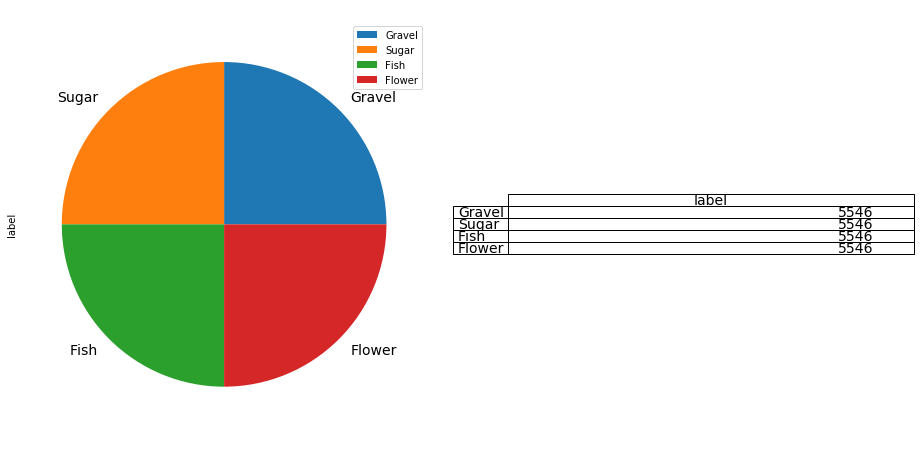

In [12]:
# sanity check: image count by label
dataset_loader.plot_pie_chart_from_pandas_series(etl_train_image_mask_df["label"].value_counts())

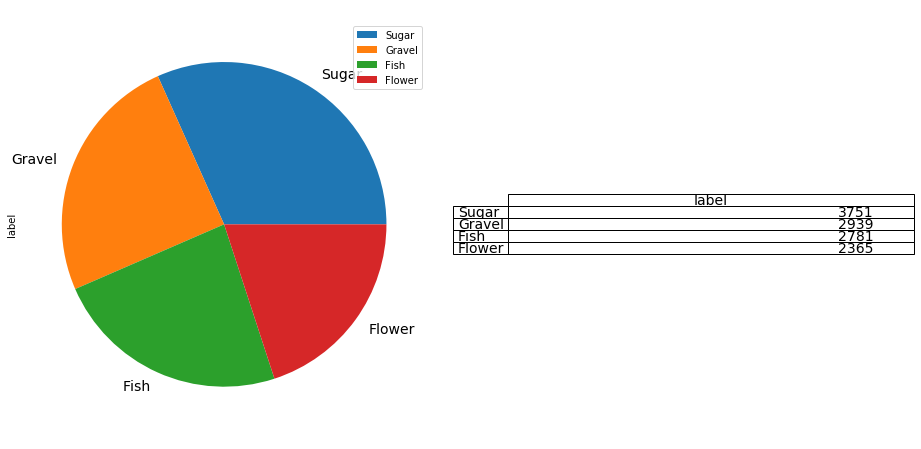

In [13]:
# sanity check: image count by label with pixel
dataset_loader.plot_pie_chart_from_pandas_series(etl_train_image_mask_df.loc[etl_train_image_mask_df['EncodedPixels'].isnull() == False, 'label'].value_counts())

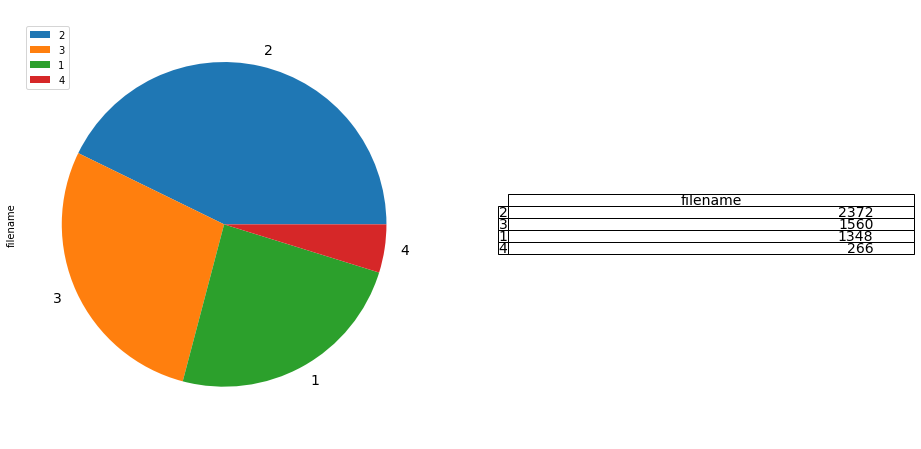

In [14]:
# sanity check: filename count by number of labels
dataset_loader.plot_pie_chart_from_pandas_series(etl_train_image_mask_df.loc[etl_train_image_mask_df['EncodedPixels'].isnull() == False, 'filename'].value_counts().value_counts())

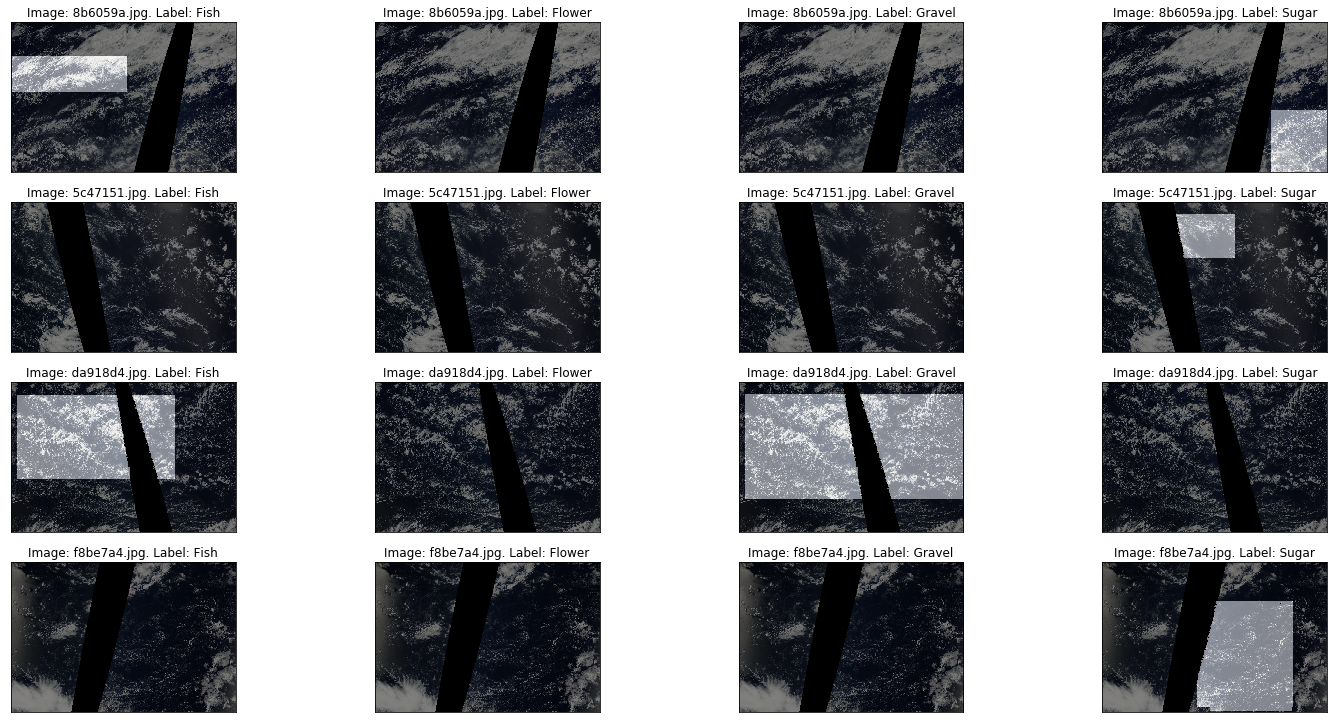

In [15]:
# sanity check: display image samples grouped by label
dataset_loader.plot_images_from_pandas_df(etl_train_image_mask_df)

### Data wrangling
Dataset ETL for model trainning

#### Augmentaion
Use package albumentations to manipulate images

In [16]:
def get_image(image_name, folder_name: str='../data/train_images'):
    """
    Input: image_name, folder_name
    Output: image
    """
    image_path = f"{folder_name}/{image_name}"
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_masks(image_name, df: pd.DataFrame, shape: tuple = (1400, 2100)):
    """
    Input: image_name, df
    Output: masks, image masks for 4 cloud classes
    """
    encoded_masks = df.loc[df['filename'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
    return masks

def visualize(image, masks, original_image=None, original_masks=None):
    """
    Visualize image and masks.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    if original_image is None and original_masks is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(masks[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_masks[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(masks[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
def visualize_with_augmentation(image, masks, augment):
    """
    Visualize with augmentation
    """
    augmented = augment(image=image, mask=masks)
    image_flipped = augmented['image']
    masks_flipped = augmented['mask']
    visualize(image_flipped, masks_flipped, original_image=image, original_masks=masks)

In [17]:
image_name = '8242ba0.jpg'
image = get_image(image_name)
masks = get_masks(image_name, etl_train_image_mask_df)

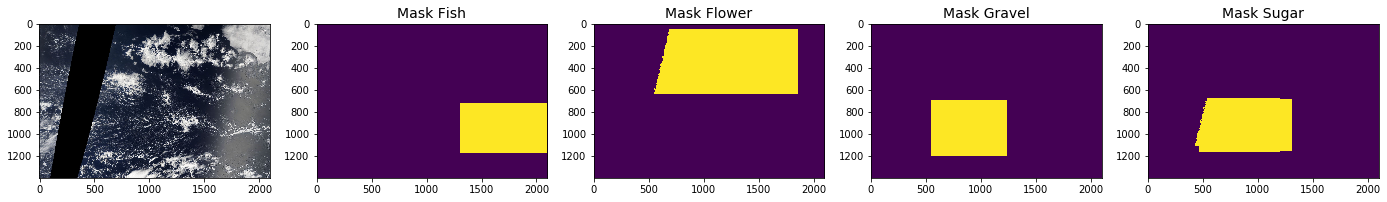

In [18]:
visualize(image, masks)

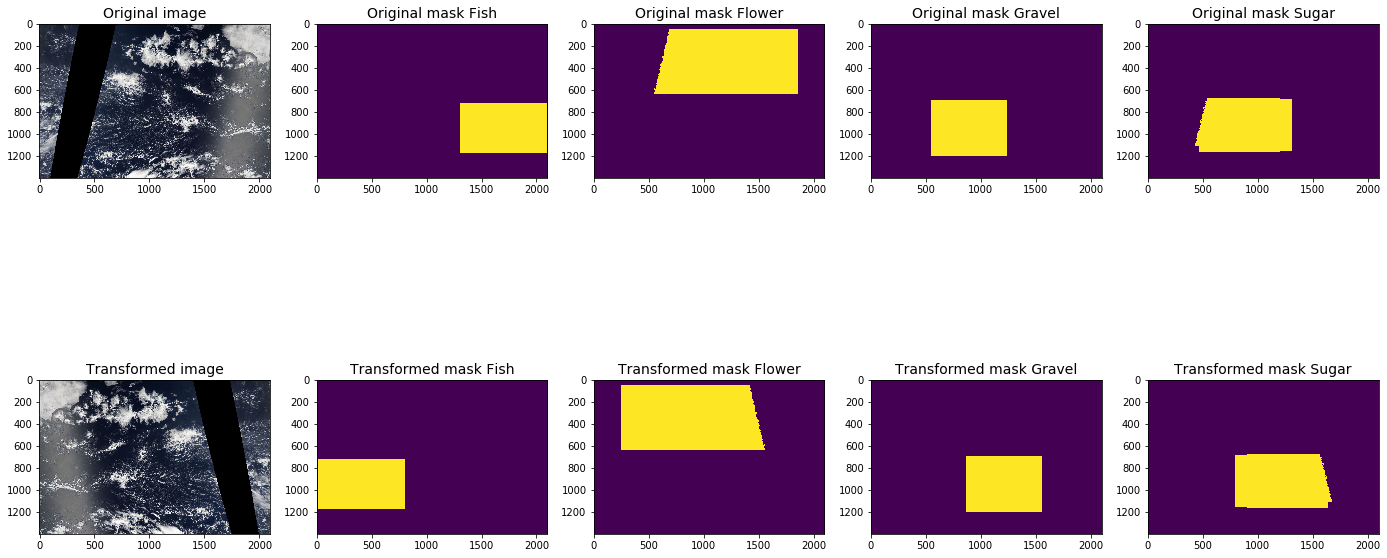

In [19]:
visualize_with_augmentation(image, masks, albu.HorizontalFlip(p=1))

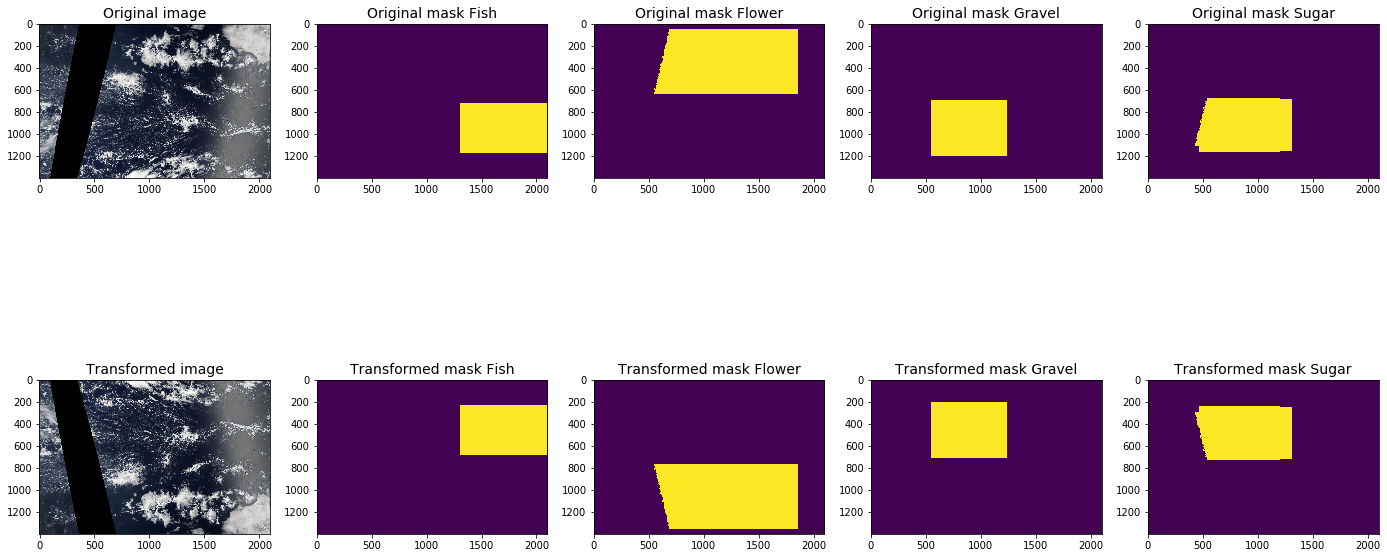

In [20]:
visualize_with_augmentation(image, masks, albu.VerticalFlip(p=1))

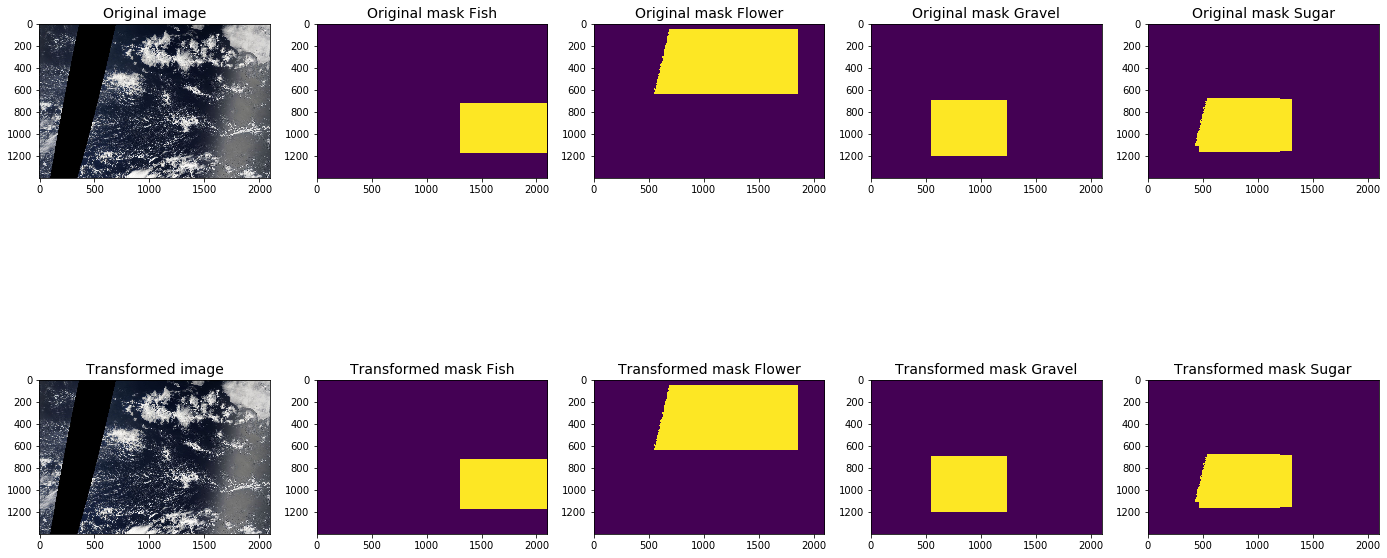

In [21]:
visualize_with_augmentation(image, masks, albu.RandomRotate90(p=1))

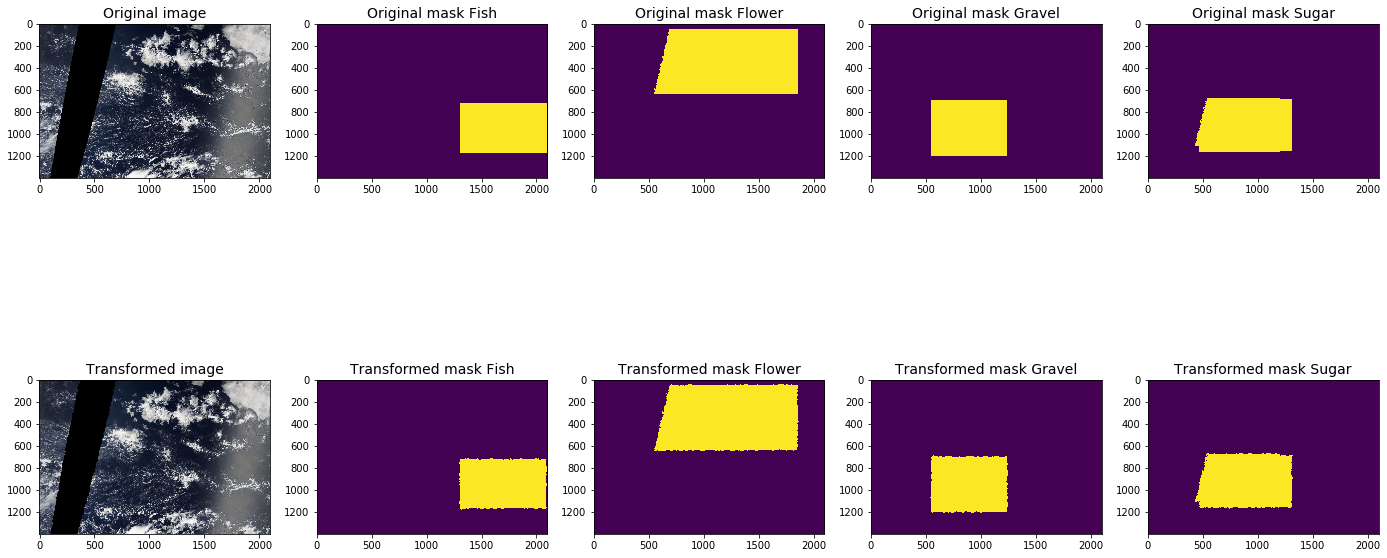

In [22]:
visualize_with_augmentation(image, masks, albu.ElasticTransform(p=1, alpha=120, sigma=120*0.05, alpha_affine=120*0.03))

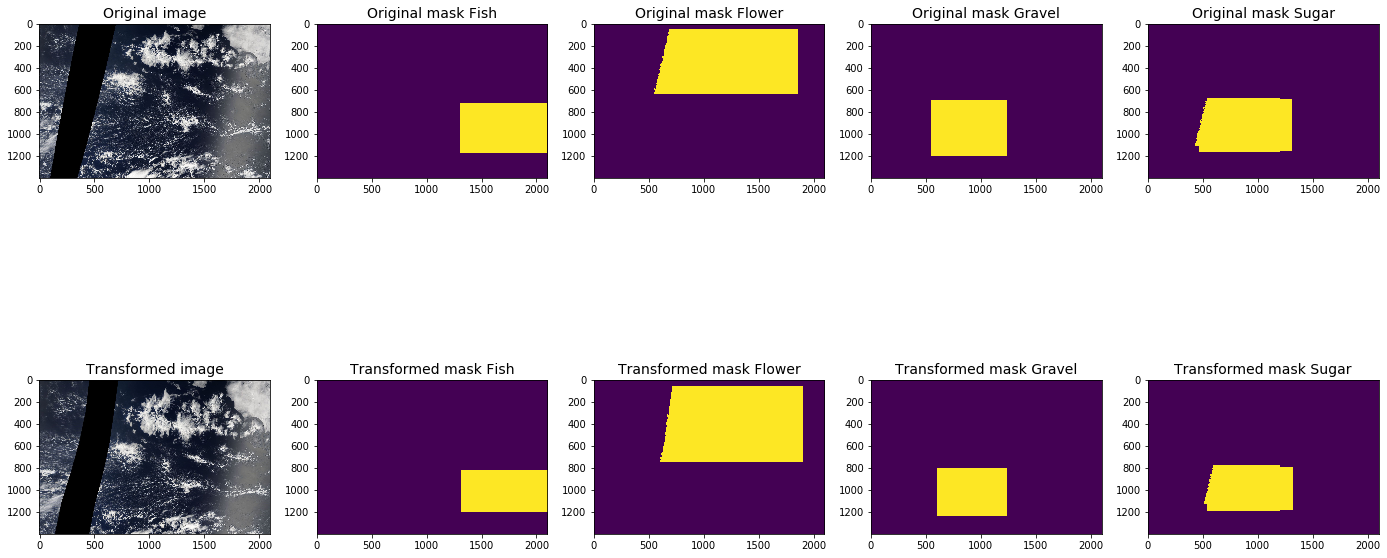

In [23]:
visualize_with_augmentation(image, masks, albu.GridDistortion(p=1))

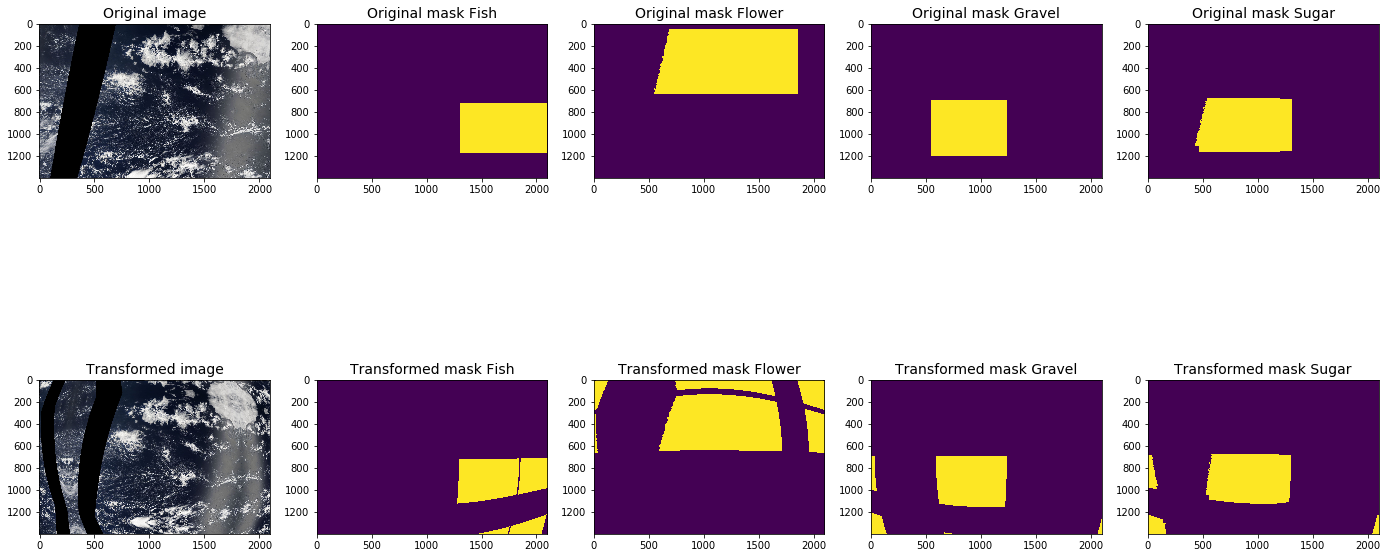

In [24]:
visualize_with_augmentation(image, masks, albu.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5))

#### Final dataset ETL

In [25]:
def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(320, 640)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
        (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [26]:
class CloudImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', image_name_arr: np.array = None,
        transforms = albu.Compose([albu.HorizontalFlip(), AT.ToTensor()]),
        preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"../data/train_images"
        else:
            self.data_folder = f"../data/test_images"
        self.image_name_arr = image_name_arr
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.image_name_arr[idx]
        image = get_image(image_name, self.data_folder)
        masks = get_masks(image_name, self.df)
        augmented = self.transforms(image=image, mask=masks)
        image = augmented['image']
        masks = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=image, mask=masks)
            image = preprocessed['image']
            masks = preprocessed['mask']
        return image, masks

    def __len__(self):
        return len(self.image_name_arr)

In [27]:
#ENCODER = 'resnet50'
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [28]:
train_dataset = CloudImageDataset(df=etl_train_image_mask_df, datatype='train', image_name_arr=train_filenames,
    transforms = get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = CloudImageDataset(df=etl_train_image_mask_df, datatype='valid', image_name_arr=valid_filenames,
    transforms = get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

/home/hua/anaconda3/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2029: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



#### Model trainning

In [29]:
ACTIVATION = None
DEVICE = 'cuda'

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/hua/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.26MB/s]


In [30]:
num_epochs = 19

# model, criterion, optimizer
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
runner = SupervisedRunner()

In [31]:
cuda = torch.device('cuda')     # Default CUDA device
torch.cuda.device_count()

1

In [32]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(), EarlyStoppingCallback(patience=5, min_delta=0.001)],
    logdir="./model_train.log",
    num_epochs=num_epochs,
    verbose=True
)

0/19 * Epoch (train): 100% 312/312 [12:11<00:00,  2.34s/it, _timers/_fps=7.894, dice=0.448, loss=0.858]
0/19 * Epoch (valid): 100% 35/35 [00:47<00:00,  1.35s/it, _timers/_fps=18.597, dice=0.343, loss=1.321]
[2019-10-11 22:18:29,272] 
0/19 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=7.3756 | _timers/batch_time=2.1842 | _timers/data_time=2.1778 | _timers/model_time=0.0064 | dice=0.3928 | loss=0.9678
0/19 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=13.0965 | _timers/batch_time=1.2294 | _timers/data_time=1.2258 | _timers/model_time=0.0035 | dice=0.4007 | loss=1.0821
1/19 * Epoch (train): 100% 312/312 [11:15<00:00,  2.17s/it, _timers/_fps=8.853, dice=0.511, loss=0.805] 
1/19 * Epoch (valid): 100% 35/35 [00:42<00:00,  1.22s/it, _timers/_fps=20.566, dice=0.488, loss=0.893]
[2019-10-11 22:30:31,250] 
1/19 * Epoch 1 (train): _base/lr=0.0100 | _base/momentum=0.9000 | _timers/_fps=8.0020 | _timers/batch_time=2.0084 | _timers/data_time=2.

13/19 * Epoch (train): 100% 312/312 [11:19<00:00,  2.18s/it, _timers/_fps=8.581, dice=0.400, loss=0.927]
13/19 * Epoch (valid): 100% 35/35 [00:43<00:00,  1.23s/it, _timers/_fps=20.539, dice=0.556, loss=0.767]
[2019-10-12 00:54:48,430] 
13/19 * Epoch 13 (train): _base/lr=0.0015 | _base/momentum=0.9000 | _timers/_fps=7.9430 | _timers/batch_time=2.0215 | _timers/data_time=2.0165 | _timers/model_time=0.0049 | dice=0.5129 | loss=0.7849
13/19 * Epoch 13 (valid): _base/lr=0.0015 | _base/momentum=0.9000 | _timers/_fps=14.4779 | _timers/batch_time=1.1097 | _timers/data_time=1.1062 | _timers/model_time=0.0035 | dice=0.5410 | loss=0.7566
14/19 * Epoch (train): 100% 312/312 [11:14<00:00,  2.16s/it, _timers/_fps=9.069, dice=0.535, loss=0.684]
14/19 * Epoch (valid): 100% 35/35 [00:42<00:00,  1.22s/it, _timers/_fps=20.511, dice=0.523, loss=0.822]
[2019-10-12 01:06:47,488] 
14/19 * Epoch 14 (train): _base/lr=0.0015 | _base/momentum=0.9000 | _timers/_fps=8.0153 | _timers/batch_time=2.0052 | _timers/dat

In [40]:
utils.plot_metrics(
    logdir="./model_train.log", 
    # specify which metrics we want to plot
    metrics=["loss", "dice", 'lr', '_base/lr']
)

#### Optimization

In [66]:
def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

sigmoid = lambda x: 1 / (1 + np.exp(-x))

def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)
    intersection = np.logical_and(img1, img2)
    return 2. * intersection.sum() / (img1.sum() + img2.sum())

In [56]:
encoded_pixels = []
loaders = {"infer": valid_loader}
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"./model_train.log/checkpoints/best.pth"),
        InferCallback()
    ],
)
valid_masks = []
probabilities = np.zeros((2220, 350, 525))
for i, (batch, output) in enumerate(tqdm.tqdm(zip(
        valid_dataset, runner.callbacks[0].predictions["logits"]))):
    image, mask = batch
    for m in mask:
        if m.shape != (350, 525):
            m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        valid_masks.append(m)

    for j, probability in enumerate(output):
        if probability.shape != (350, 525):
            probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        probabilities[i * 4 + j, :, :] = probability

=> loading checkpoint ./model_train.log/checkpoints/best.pth
loaded checkpoint ./model_train.log/checkpoints/best.pth (epoch 18)




0it [00:00, ?it/s]

2it [00:00, 11.83it/s]

Top best models:





4it [00:00, 11.84it/s]

6it [00:00, 12.04it/s]

8it [00:00, 12.78it/s]

10it [00:00, 12.76it/s]

12it [00:00, 11.99it/s]

14it [00:01, 11.76it/s]

16it [00:01, 11.92it/s]

18it [00:01, 11.67it/s]

20it [00:01, 11.23it/s]

22it [00:01, 12.03it/s]

24it [00:02, 11.65it/s]

26it [00:02, 12.01it/s]

28it [00:02, 12.47it/s]

30it [00:02, 12.88it/s]

32it [00:02, 12.92it/s]

34it [00:02, 13.11it/s]

36it [00:02, 13.14it/s]

38it [00:03, 13.15it/s]

40it [00:03, 13.13it/s]

42it [00:03, 13.26it/s]

44it [00:03, 12.78it/s]

46it [00:03, 13.31it/s]

48it [00:03, 13.78it/s]

50it [00:03, 13.67it/s]

52it [00:04, 13.03it/s]

54it [00:04, 13.02it/s]

56it [00:04, 12.72it/s]

58it [00:04, 13.47it/s]

60it [00:04, 12.74it/s]

62it [00:04, 12.73it/s]

64it [00:05, 12.84it/s]

66it [00:05, 12.80it/s]

68it [00:05, 12.90it/s]

70it [00:05, 12.85it/s]

72it [00:05, 12.92it/s]

74it [00:05, 12.78it/s]

76it [00:05, 13.02it/s]

78it [00:06, 12.61it/s]

80it [00:06, 12.69it/s]

82it [00:06, 12.76it/s]

8

518it [00:39, 12.66it/s]

520it [00:39, 13.28it/s]

522it [00:39, 13.33it/s]

524it [00:39, 13.23it/s]

526it [00:40, 13.39it/s]

528it [00:40, 13.64it/s]

530it [00:40, 13.83it/s]

532it [00:40, 14.07it/s]

534it [00:40, 14.24it/s]

536it [00:40, 14.53it/s]

538it [00:40, 13.80it/s]

540it [00:41, 13.25it/s]

542it [00:41, 14.01it/s]

544it [00:41, 13.59it/s]

546it [00:41, 13.31it/s]

548it [00:41, 13.21it/s]

550it [00:41, 12.93it/s]

552it [00:41, 13.30it/s]

555it [00:42, 13.17it/s]


In [60]:
class_params = {}
for class_id in range(4):
    print(class_id)
    attempts = []
    for t in range(0, 100, 5):
        t /= 100
        for ms in [0, 100, 1200, 5000, 10000]:
            masks = []
            for i in range(class_id, len(probabilities), 4):
                probability = probabilities[i]
                predict, num_predict = post_process(sigmoid(probability), t, ms)
                masks.append(predict)

            d = []
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))

            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]  
    class_params[class_id] = (best_threshold, best_size)

0
    threshold   size      dice
59       0.55  10000  0.618213
64       0.60  10000  0.609194
79       0.75  10000  0.608070
54       0.50  10000  0.607828
69       0.65  10000  0.607145
1
    threshold   size      dice
79       0.75  10000  0.762208
69       0.65  10000  0.761802
74       0.70  10000  0.760374
84       0.80  10000  0.760288
64       0.60  10000  0.760252
2
    threshold   size      dice
59       0.55  10000  0.619281
64       0.60  10000  0.618963
54       0.50  10000  0.618849
49       0.45  10000  0.618820
69       0.65  10000  0.615111
3
    threshold   size      dice
54       0.50  10000  0.608444
59       0.55  10000  0.606836
63       0.60   5000  0.602363
49       0.45  10000  0.599774
44       0.40  10000  0.599603


#### Prediction

In [61]:
import gc
torch.cuda.empty_cache()
gc.collect()

34919

In [62]:
# etl on test image mask dataframe
etl_test_image_mask_df = dataset_loader.etl_train_image_mask_df(test_image_pred_sample_df)
etl_test_image_mask_df.head()

EncodedPixels     filename   label
0           1 1  002f507.jpg    Fish
1           1 1  002f507.jpg  Flower
2           1 1  002f507.jpg  Gravel
3           1 1  002f507.jpg   Sugar
4           1 1  0035ae9.jpg    Fish

In [63]:
sub = pd.read_csv(f'../data/sample_submission.csv')
test_filenames = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [64]:
test_dataset = CloudImageDataset(df=etl_test_image_mask_df, datatype='test', image_name_arr=test_filenames,
                                 transforms = get_validation_augmentation(),
                                 preprocessing=get_preprocessing(preprocessing_fn))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

loaders = {"test": test_loader}

In [67]:
encoded_pixels = []
image_id = 0
for i, test_batch in enumerate(tqdm.tqdm(loaders['test'])):
    runner_out = runner.predict_batch({"features": test_batch[0].cuda()})['logits']
    for i, batch in enumerate(runner_out):
        for probability in batch:
            probability = probability.cpu().detach().numpy()
            if probability.shape != (350, 525):
                probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
            predict, num_predict = post_process(sigmoid(probability), class_params[image_id % 4][0], class_params[image_id % 4][1])
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(predict)
                encoded_pixels.append(r)
            image_id += 1



  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 1/463 [00:00<05:20,  1.44it/s]

  0%|          | 2/463 [00:01<05:40,  1.36it/s]

  1%|          | 3/463 [00:02<06:02,  1.27it/s]

  1%|          | 4/463 [00:03<05:57,  1.28it/s]

  1%|          | 5/463 [00:03<05:49,  1.31it/s]

  1%|▏         | 6/463 [00:04<05:50,  1.31it/s]

  2%|▏         | 7/463 [00:05<05:47,  1.31it/s]

  2%|▏         | 8/463 [00:06<05:49,  1.30it/s]

  2%|▏         | 9/463 [00:07<05:51,  1.29it/s]

  2%|▏         | 10/463 [00:07<05:49,  1.29it/s]

  2%|▏         | 11/463 [00:08<05:49,  1.29it/s]

  3%|▎         | 12/463 [00:09<05:50,  1.29it/s]

  3%|▎         | 13/463 [00:10<05:43,  1.31it/s]

  3%|▎         | 14/463 [00:10<05:47,  1.29it/s]

  3%|▎         | 15/463 [00:11<05:55,  1.26it/s]

  3%|▎         | 16/463 [00:12<05:51,  1.27it/s]

  4%|▎         | 17/463 [00:13<05:42,  1.30it/s]

  4%|▍         | 18/463 [00:14<05:43,  1.30it/s]

  4%|▍         | 19/463 [00:14<05:37,  1.31it/s]

  4%|▍         |

 31%|███▏      | 145/463 [01:53<04:02,  1.31it/s]

 32%|███▏      | 146/463 [01:54<04:01,  1.31it/s]

 32%|███▏      | 147/463 [01:54<04:00,  1.31it/s]

 32%|███▏      | 148/463 [01:55<04:08,  1.27it/s]

 32%|███▏      | 149/463 [01:56<04:10,  1.25it/s]

 32%|███▏      | 150/463 [01:57<04:21,  1.20it/s]

 33%|███▎      | 151/463 [01:58<04:17,  1.21it/s]

 33%|███▎      | 152/463 [01:59<04:11,  1.24it/s]

 33%|███▎      | 153/463 [01:59<04:04,  1.27it/s]

 33%|███▎      | 154/463 [02:00<04:01,  1.28it/s]

 33%|███▎      | 155/463 [02:01<04:02,  1.27it/s]

 34%|███▎      | 156/463 [02:02<04:19,  1.18it/s]

 34%|███▍      | 157/463 [02:03<04:08,  1.23it/s]

 34%|███▍      | 158/463 [02:04<04:14,  1.20it/s]

 34%|███▍      | 159/463 [02:04<04:06,  1.24it/s]

 35%|███▍      | 160/463 [02:05<04:05,  1.23it/s]

 35%|███▍      | 161/463 [02:06<04:06,  1.23it/s]

 35%|███▍      | 162/463 [02:07<04:04,  1.23it/s]

 35%|███▌      | 163/463 [02:07<03:58,  1.26it/s]

 35%|███▌      | 164/463 [02:08

 62%|██████▏   | 288/463 [03:48<02:16,  1.29it/s]

 62%|██████▏   | 289/463 [03:49<02:11,  1.32it/s]

 63%|██████▎   | 290/463 [03:49<02:11,  1.31it/s]

 63%|██████▎   | 291/463 [03:50<02:07,  1.35it/s]

 63%|██████▎   | 292/463 [03:51<02:08,  1.33it/s]

 63%|██████▎   | 293/463 [03:51<02:05,  1.36it/s]

 63%|██████▎   | 294/463 [03:52<02:05,  1.35it/s]

 64%|██████▎   | 295/463 [03:53<02:02,  1.37it/s]

 64%|██████▍   | 296/463 [03:54<02:05,  1.33it/s]

 64%|██████▍   | 297/463 [03:54<02:01,  1.36it/s]

 64%|██████▍   | 298/463 [03:55<02:02,  1.34it/s]

 65%|██████▍   | 299/463 [03:56<02:00,  1.36it/s]

 65%|██████▍   | 300/463 [03:57<02:01,  1.35it/s]

 65%|██████▌   | 301/463 [03:57<01:58,  1.36it/s]

 65%|██████▌   | 302/463 [03:58<01:59,  1.35it/s]

 65%|██████▌   | 303/463 [03:59<01:56,  1.37it/s]

 66%|██████▌   | 304/463 [04:00<01:57,  1.35it/s]

 66%|██████▌   | 305/463 [04:00<01:54,  1.38it/s]

 66%|██████▌   | 306/463 [04:01<01:59,  1.32it/s]

 66%|██████▋   | 307/463 [04:02

 93%|█████████▎| 431/463 [05:35<00:23,  1.34it/s]

 93%|█████████▎| 432/463 [05:36<00:23,  1.33it/s]

 94%|█████████▎| 433/463 [05:36<00:22,  1.35it/s]

 94%|█████████▎| 434/463 [05:37<00:21,  1.35it/s]

 94%|█████████▍| 435/463 [05:38<00:20,  1.37it/s]

 94%|█████████▍| 436/463 [05:39<00:20,  1.34it/s]

 94%|█████████▍| 437/463 [05:39<00:19,  1.36it/s]

 95%|█████████▍| 438/463 [05:40<00:18,  1.33it/s]

 95%|█████████▍| 439/463 [05:41<00:17,  1.34it/s]

 95%|█████████▌| 440/463 [05:42<00:17,  1.31it/s]

 95%|█████████▌| 441/463 [05:42<00:16,  1.35it/s]

 95%|█████████▌| 442/463 [05:43<00:15,  1.33it/s]

 96%|█████████▌| 443/463 [05:44<00:14,  1.36it/s]

 96%|█████████▌| 444/463 [05:45<00:14,  1.33it/s]

 96%|█████████▌| 445/463 [05:45<00:13,  1.36it/s]

 96%|█████████▋| 446/463 [05:46<00:12,  1.34it/s]

 97%|█████████▋| 447/463 [05:47<00:11,  1.36it/s]

 97%|█████████▋| 448/463 [05:48<00:11,  1.35it/s]

 97%|█████████▋| 449/463 [05:48<00:10,  1.38it/s]

 97%|█████████▋| 450/463 [05:49

In [68]:
sub['EncodedPixels'] = encoded_pixels
sub.to_csv('submission.csv', columns=['Image_Label', 'EncodedPixels'], index=False)